In [13]:
from argparse import ArgumentParser

import torch
import wandb
import numpy as np
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from preprocessing.data_pipeline import build_data_pipeline
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from preprocessing.preprocess_ucr import UCRDatasetImporter
from experiments.exp_maskgit import ExpMaskGIT
from evaluation.model_eval import Evaluation
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from models.stage2.maskgit import MaskGIT
from models.stage2.full_embedding_maskgit import Full_Embedding_MaskGIT
import os
from pathlib import Path
import tempfile

# from evaluation.evaluation import Evaluation
from utils import (
    get_root_dir,
    load_yaml_param_settings,
    save_model,
    model_filename,
)



config_dir = get_root_dir().joinpath("configs", "config.yaml")
dataset="UWaveGestureLibraryAll"
config = load_yaml_param_settings(config_dir)
config["dataset"]["dataset_name"] = dataset

dataset_importer = UCRDatasetImporter(**config["dataset"])
batch_size = config["dataset"]["batch_sizes"]["stage1"]

train_data_loader_no_aug = build_data_pipeline(
    batch_size, dataset_importer, config, augment=False, kind="train"
)

test_data_loader_no_aug = build_data_pipeline(
    batch_size, dataset_importer, config, augment=False, kind="test"
)


input_length = train_data_loader_no_aug.dataset.X.shape[-1]

n_classes = len(np.unique(train_data_loader_no_aug.dataset.Y))

maskgit = Full_Embedding_MaskGIT(
    input_length,
    **config["MaskGIT"],
    config=config,
    n_classes=n_classes,
    finetune_codebook=False,
    load_finetuned_codebook=True,
    device="cuda"
)

# load
fname = f"maskgit-{dataset}.ckpt"
fname = f"{model_filename(config, 'fullembed-maskgit-finetuned')}-{'UWaveGestureLibraryAll'}.ckpt"
        
try:
    ckpt_fname = os.path.join("saved_models", fname)
    maskgit.load_state_dict(torch.load(ckpt_fname), strict=False)
except FileNotFoundError:
    ckpt_fname = Path(tempfile.gettempdir()).joinpath(fname)
    maskgit.load_state_dict(torch.load(ckpt_fname), strict=False)
try:
    ckpt_fname = os.path.join("saved_models", fname)
    maskgit.load_state_dict(torch.load(ckpt_fname), strict=False)
except FileNotFoundError:
    ckpt_fname = Path(tempfile.gettempdir()).joinpath(fname)
    maskgit.load_state_dict(torch.load(ckpt_fname), strict=False)



self.X_train.shape: (896, 945)
self.X_test.shape: (3582, 945)
# unique labels (train): [0 1 2 3 4 5 6 7]
# unique labels (test): [0 1 2 3 4 5 6 7]
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
vibcreg-encoder-seed-4-LPCPWZ-UWaveGestureLibraryAll.ckpt
vibcreg encoder loaded
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
vibcreg-decoder-seed-4-LPCPWZ-UWaveGestureLibraryAll.ckpt
vibcreg decoder loaded
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
vibcreg-vqmodel-seed-4-LPCPWZ-UWaveGestureLibraryAll.ckpt
vibcreg vqmodel loaded
finetuned codebook loaded


In [14]:
stage1_cb = maskgit.vq_model.codebook
stage2_cb = maskgit.cb_stage1

In [15]:
stage1_cb

tensor([[-0.2977,  0.2289,  0.4003,  ..., -0.2181,  1.1105,  0.9847],
        [ 0.5054,  0.1689, -0.2334,  ..., -0.1686, -0.5281, -0.3896],
        [-0.1107,  0.2660,  0.6332,  ..., -0.2335,  0.4451,  0.5608],
        ...,
        [-0.9841, -1.2306, -0.7419,  ..., -1.1855,  0.6724,  0.9478],
        [ 0.7452,  0.3143,  0.4165,  ..., -0.7036, -0.9646, -0.0593],
        [ 0.4651,  0.8534,  1.2296,  ...,  0.2368,  1.0816,  0.7424]])

In [16]:
stage2_cb

Parameter containing:
tensor([[-0.2589, -0.1280,  0.2571,  ..., -0.1675,  1.3970,  1.3162],
        [ 0.4781,  0.3254, -0.3517,  ..., -0.2456, -0.6851, -0.5480],
        [-0.0698,  0.2463,  0.6989,  ..., -0.2371,  0.4823,  0.4972],
        ...,
        [-1.0247, -1.1715, -0.6865,  ..., -1.2827,  0.6443,  0.9851],
        [ 0.7702,  0.1754,  0.5441,  ..., -0.8783, -0.9642, -0.0966],
        [ 0.3035,  0.9840,  1.2012,  ...,  0.2213,  0.9407,  0.6706]],
       device='cuda:0')

In [17]:
print(torch.where(stage1_cb.to("cpu") != stage2_cb.to("cpu")))

(tensor([ 0,  0,  0,  ..., 31, 31, 31]), tensor([ 0,  1,  2,  ..., 61, 62, 63]))


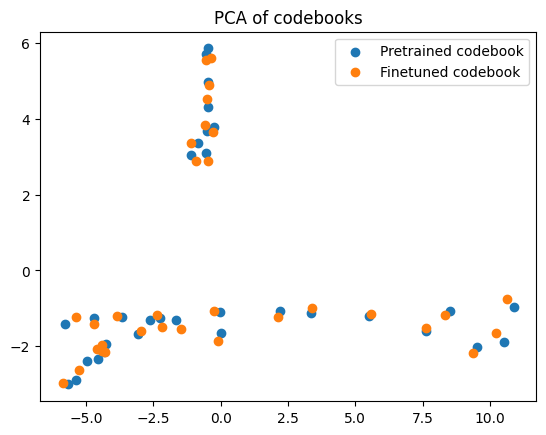

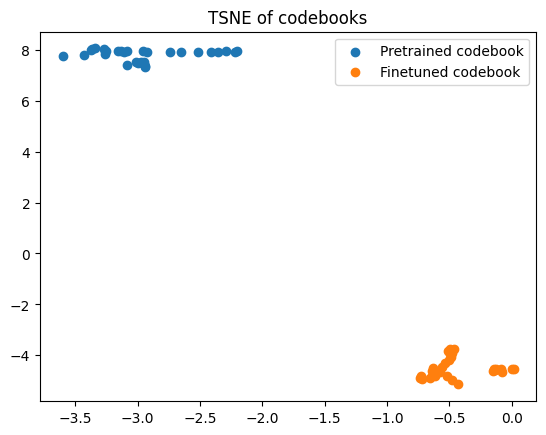

In [28]:
#pca
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(stage1_cb.cpu().detach().numpy())
stage1_cb_pca = pca.transform(stage1_cb.cpu().detach().numpy())

pca = PCA(n_components=2)
pca.fit(stage2_cb.cpu().detach().numpy())
stage2_cb_pca = pca.transform(stage2_cb.cpu().detach().numpy())

plt.scatter(stage1_cb_pca[:,0], stage1_cb_pca[:,1], label="Pretrained codebook")
plt.scatter(stage2_cb_pca[:,0], stage2_cb_pca[:,1], label="Finetuned codebook")
plt.legend()
plt.title("PCA of codebooks")
plt.show()

#tsne
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
stage1_cb_tsne = tsne.fit_transform(stage1_cb.cpu().detach().numpy())

tsne = TSNE(n_components=2)
stage2_cb_tsne = tsne.fit_transform(stage2_cb.cpu().detach().numpy())

plt.scatter(stage1_cb_tsne[:,0], stage1_cb_tsne[:,1], label="Pretrained codebook")
plt.scatter(stage2_cb_tsne[:,0], stage2_cb_tsne[:,1], label="Finetuned codebook")
plt.legend()
plt.title("TSNE of codebooks")
plt.show()

# 2D plot




